In [29]:
#!/usr/bin/env python3

import os
import sys
import numpy as np 
import argparse 
import time 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from tc.tc_fc import TTLinear 

from torchvision import datasets, transforms

seed = 7
np.random.seed(seed)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size =200
input_tensor = [7, 4, 7, 4]
hidden_tensors= [[8, 4, 8, 4], [8, 4, 8, 4], [4, 2, 4, 4]]
n_epochs = 5


class tt_autoencoder(nn.Module):
    def __init__(self, hidden_tensors, input_tensor, output_dim, tt_rank):
        super(tt_autoencoder, self).__init__()
        self.encoder1 = nn.Sequential(TTLinear(input_tensor, hidden_tensors[0], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[0], hidden_tensors[1], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[1], hidden_tensors[2], tt_rank=tt_rank))
        self.decoder1 = nn.Sequential(TTLinear(hidden_tensors[2],hidden_tensors[1], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[1],hidden_tensors[0], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[0],input_tensor, tt_rank=tt_rank))

    def forward(self, inputs):
        ### Encoder layer
        out = self.encoder1(inputs)
        ### Decoder Layer with activation
        out = F.sigmoid(self.decoder1(out))
        return out

In [30]:
if __name__=='__main__':


    ### get data
    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # load the training and test datasets
    train_data = datasets.MNIST(root='data', train=True,
                                       download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False,
                                      download=True, transform=transform)
    # Create training and test dataloaders

    # number of subprocesses to use for data loading
    num_workers = 0
    # how many samples per batch to load
    batch_size = 20

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    tt_rank = [1, 2, 2, 2, 1]
    print('Building a Tensor-Train model...')
    model = tt_autoencoder(hidden_tensors, input_tensor, 10, tt_rank).to(device)
    
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    lr = 0.001
    # specify loss function
    criterion = nn.BCELoss()

    # specify loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    # number of epochs to train the model
    n_epochs = 5

Building a Tensor-Train model...
Model's state_dict:
encoder1.0.b 	 torch.Size([1])
encoder1.0.W_cores.0 	 torch.Size([1, 7, 8, 2])
encoder1.0.W_cores.1 	 torch.Size([2, 4, 4, 2])
encoder1.0.W_cores.2 	 torch.Size([2, 7, 8, 2])
encoder1.0.W_cores.3 	 torch.Size([2, 4, 4, 1])
encoder1.1.b 	 torch.Size([1])
encoder1.1.W_cores.0 	 torch.Size([1, 8, 8, 2])
encoder1.1.W_cores.1 	 torch.Size([2, 4, 4, 2])
encoder1.1.W_cores.2 	 torch.Size([2, 8, 8, 2])
encoder1.1.W_cores.3 	 torch.Size([2, 4, 4, 1])
encoder1.2.b 	 torch.Size([1])
encoder1.2.W_cores.0 	 torch.Size([1, 8, 4, 2])
encoder1.2.W_cores.1 	 torch.Size([2, 4, 2, 2])
encoder1.2.W_cores.2 	 torch.Size([2, 8, 4, 2])
encoder1.2.W_cores.3 	 torch.Size([2, 4, 4, 1])
decoder1.0.b 	 torch.Size([1])
decoder1.0.W_cores.0 	 torch.Size([1, 4, 8, 2])
decoder1.0.W_cores.1 	 torch.Size([2, 2, 4, 2])
decoder1.0.W_cores.2 	 torch.Size([2, 4, 8, 2])
decoder1.0.W_cores.3 	 torch.Size([2, 4, 4, 1])
decoder1.1.b 	 torch.Size([1])
decoder1.1.W_cores.0 	 t

In [ ]:
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))


torch.save(model.state_dict(),"ae_tt.pt")

Epoch: 1 	Training Loss: 14.060495


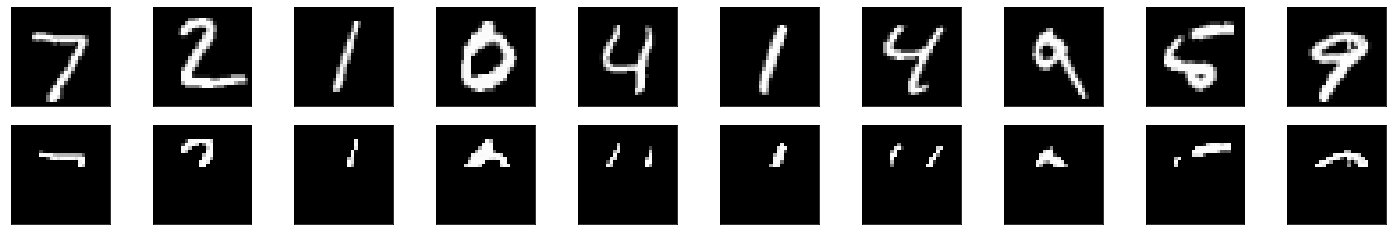

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten.to(device))
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)



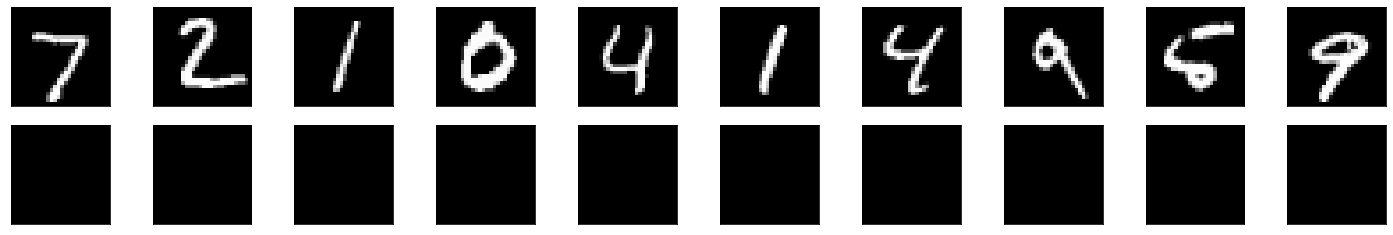

In [28]:

def show_rec():
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    images_flatten = images.view(images.size(0), -1)
    # get sample outputs
    output = model(images_flatten.to(device))
    # prep images for display
    images = images.numpy()

    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

show_rec()